# 1. Подготовка данных и обучение нейронных сетей

In [ ]:
from keras.layers import SimpleRNN, LSTM, SimpleRNNCell
from keras.models import Sequential

import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Flatten, Dropout
from tensorflow.keras.layers import GRU
from tensorflow.keras.models import Model

from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

pd.options.display.float_format = "{:.2f}".format

plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (15, 15)

In [ ]:
data = pd.read_csv('https://drive.usercontent.google.com/u/0/uc?id=1xwXieDVy1RKdfiJ6am_nNWp6XhAYdhNb&export=download')

In [ ]:
data.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


Столбец `Month` сделаем индексом. Будем обучать модель, используя только один признак - `Passengers`.

In [ ]:
data['Month'] = pd.to_datetime(data['Month'])

data.set_index('Month', inplace=True)
data.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


Сразу применим масштабирование к временному ряду.

In [ ]:
scaler = MinMaxScaler()

data['Passengers'] = scaler.fit_transform(data['Passengers'].values.reshape(-1,1))

Далее подготовим данные для модели с одномерным входом по аналогии со скринкастом Web5. На вход в модель будут подаваться последние 12 значений пассажиров, и модель необходимо обучить прогнозировать число пассажиров на следующем шаге по времени.

In [ ]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i + target_size])
    return np.array(data), np.array(labels)

In [ ]:
past_history = 12
future_target = 0

train_size = 108

X_train, y_train = univariate_data(data.values, 0, train_size,
                                           past_history,
                                           future_target)

X_val, y_val = univariate_data(data.values, train_size, None,
                                       past_history,
                                       future_target)

In [ ]:
X_train[0], y_train[0]

(array([[0.01544402],
        [0.02702703],
        [0.05405405],
        [0.04826255],
        [0.03281853],
        [0.05984556],
        [0.08494208],
        [0.08494208],
        [0.06177606],
        [0.02895753],
        [0.        ],
        [0.02702703]]),
 array([0.02123552]))

In [ ]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((96, 12, 1), (96, 1), (24, 12, 1), (24, 1))

С помощью tf.data выполним перемешивание shuffle, пакетирование batch и кэширование cache набора данных.

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

# Перемешиваем и пакетируем данные для обучения
batch_size = 8
buffer_size = 1000

train_dataset = train_dataset.shuffle(buffer_size).batch(batch_size).cache()
val_dataset = val_dataset.batch(batch_size).cache()

In [ ]:
for input, _ in train_dataset:
    print(input.shape)
    break

(8, 12, 1)


In [ ]:
def plot_predictions(train_true, train_pred, test_true, test_pred):
    plt.figure(figsize=(10, 6))

    # График для тренировочных данных
    plt.plot(train_true, label='Train True', color='blue')
    plt.plot(train_pred, label='Train Predictions', color='green', linestyle='--')

    # График для тестовых данных
    plt.plot(range(len(train_true), len(train_true) + len(test_true)),
             test_true, label='Test True', color='red')
    plt.plot(range(len(train_true), len(train_true) + len(test_true)),
             test_pred, label='Test Predictions', color='orange', linestyle='--')

    plt.title('True vs Predicted')
    plt.xlabel('Sample')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

## 1. Обучение Simple RNN

Для начала обучим нейронную сеть Simple RNN.

In [ ]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='loss', patience=20)

model_rnn = Sequential([
    SimpleRNN(64,
              input_shape=(input.shape[1], input.shape[2])),
    Dense(1)
])

model_rnn.summary()

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_44 (SimpleRNN)   (None, 64)                4224      
                                                                 
 dense_49 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4289 (16.75 KB)
Trainable params: 4289 (16.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/100
12/12 [==============================] - 2s 35ms/step - loss: 0.0245 - val_loss: 0.0777
Epoch 2/100
12/12 [==============================] - 0s 5ms/step - loss: 0.0046 - val_loss: 0.0351
Epoch 3/100
12/12 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 0.0181
Epoch 4/100
12/12 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0269
Epoch 5/100
12/12 [==============================] - 0s 8ms/step - loss: 0.0019 - val_loss: 0.0283
Epoch 6/100
12/12 [==============================] - 0s 5ms/step - loss: 0.0017 - val_loss: 0.0240
Epoch 7/100
12/12 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 0.0208
Epoch 8/100
12/12 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0190
Epoch 9/100
12/12 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0177
Epoch 10/100
12/12 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0166
Epoch 11

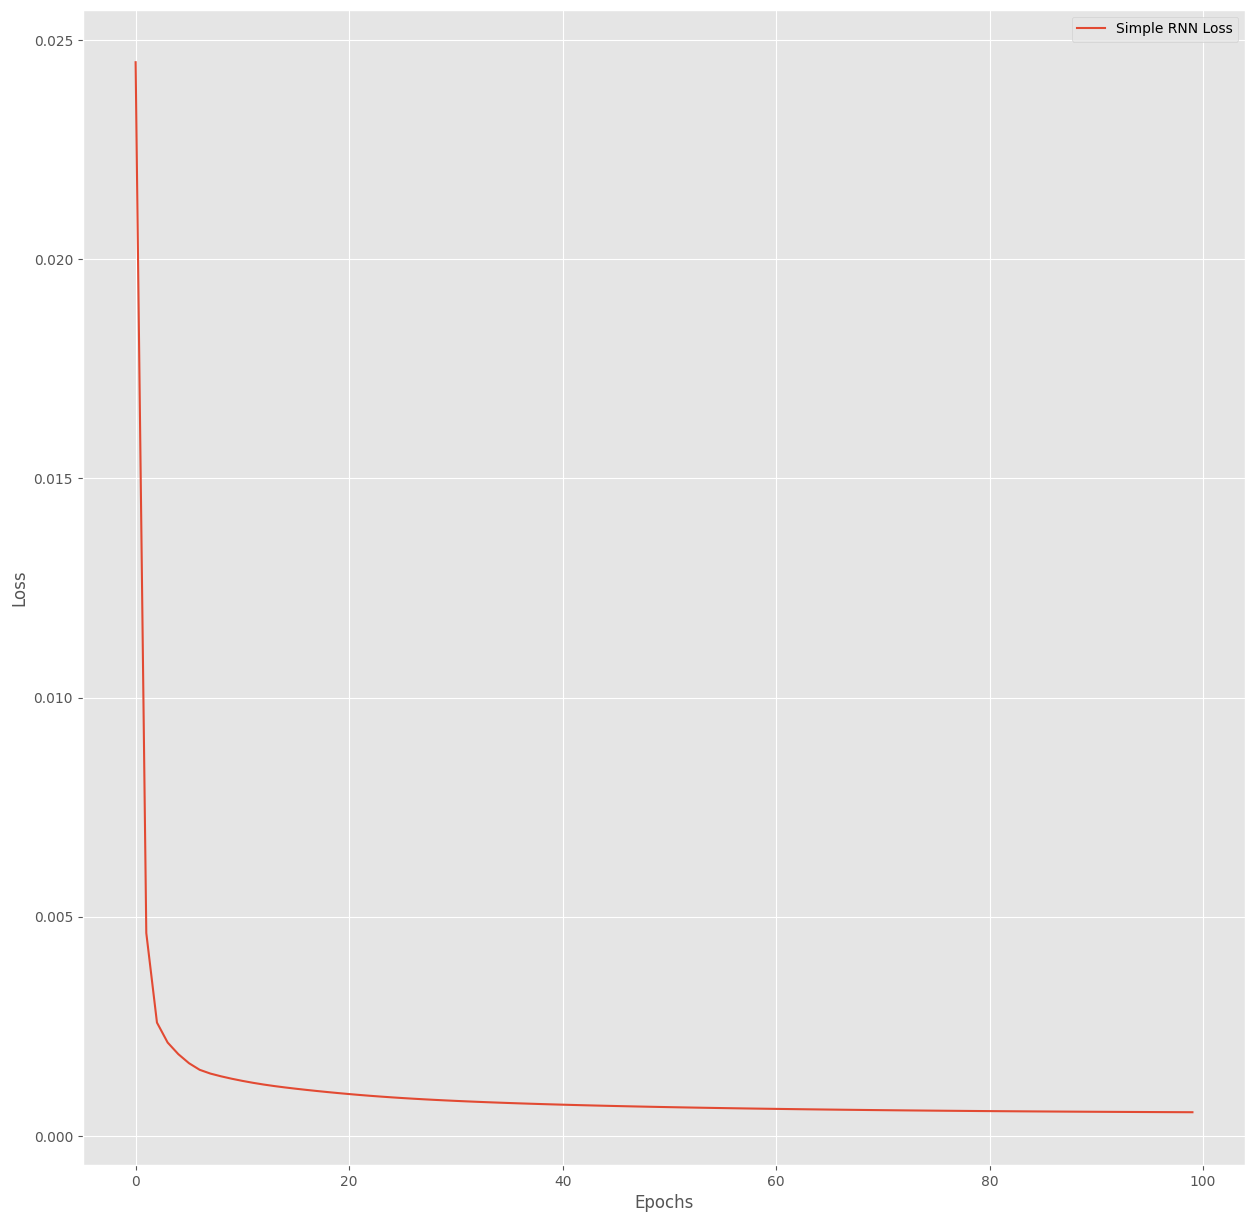

In [ ]:
model_rnn.compile(optimizer='adam', loss='mse')

history_rnn = model_rnn.fit(train_dataset,
                            epochs=100,
                            batch_size=batch_size,
                            verbose=1,
                            validation_data=val_dataset,
                            callbacks=[early_stop])

# Визуализация процесса обучения
plt.plot(history_rnn.history['loss'], label='Simple RNN Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 132ms/step
Val MSE: 0.0012


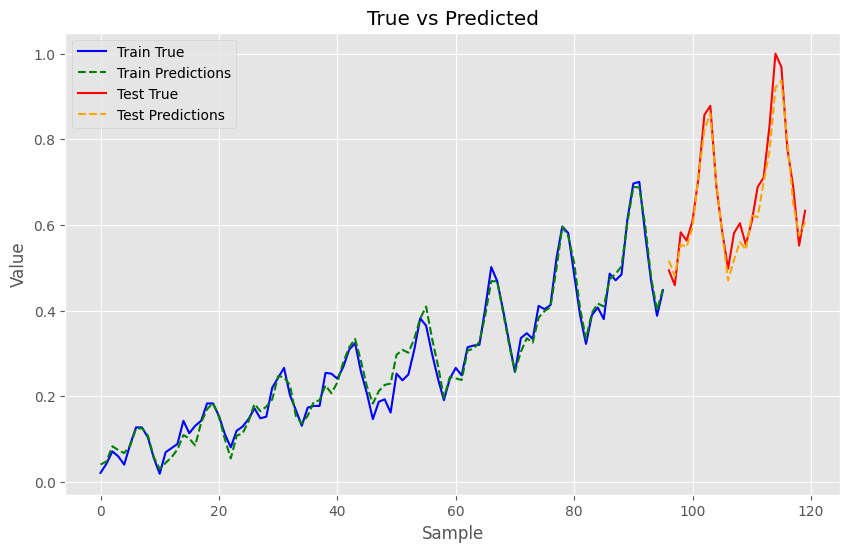

In [ ]:
rnn_predict_train = model_rnn.predict(X_train).flatten()
rnn_predict_true = model_rnn.predict(X_val).flatten()
print(f"Val MSE: {history_rnn.history['val_loss'][-1]:.4f}")

plot_predictions(y_train, rnn_predict_train, y_val, rnn_predict_true)

Simple RNN на тестовых данных показывает результат MSE = 0.0014, это может говорить об очень хорошем качестве модели, но проверим качество нейронной сети на кросс-валидации с отрисовыванием графиков.

2/2 [==============================] - 0s 7ms/step
Val MSE: 0.0007


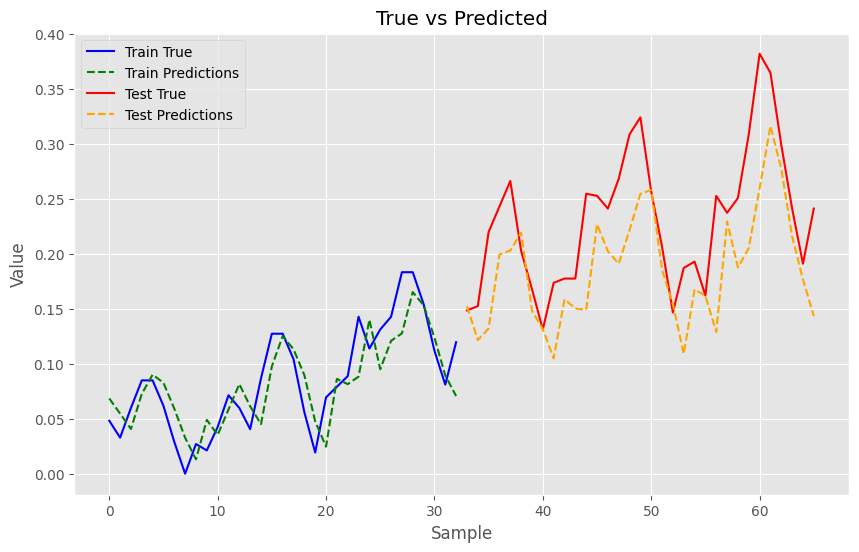

2/2 [==============================] - 0s 4ms/step
Val MSE: 0.0013


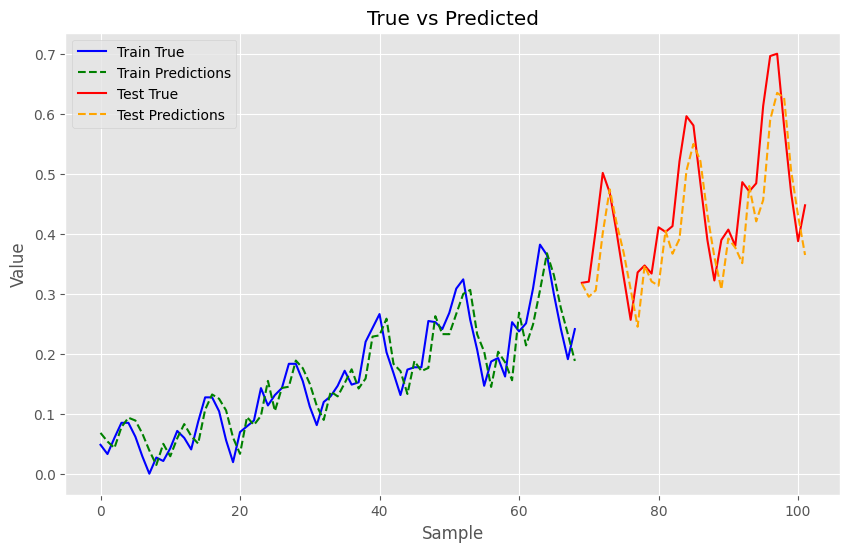

2/2 [==============================] - 0s 5ms/step
Val MSE: 0.0022


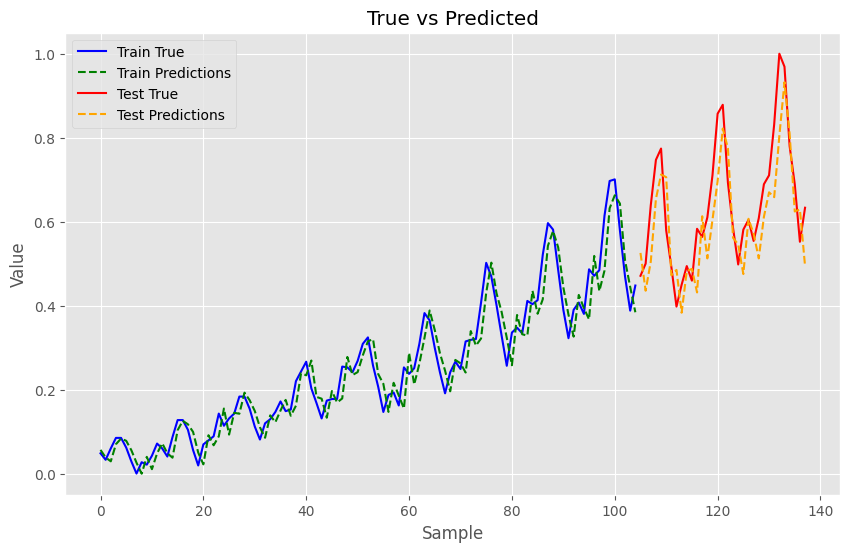

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=3)

for train_index, test_index in tscv.split(data):
    train_data, test_data = data.iloc[train_index], data.iloc[test_index]

    def create_dataset(dataset, time_steps=1):
        X, y = [], []
        for i in range(len(dataset) - time_steps):
            X.append(dataset.iloc[i:(i + time_steps)])
            y.append(dataset.iloc[i + time_steps])
        return np.array(X), np.array(y)

    # для теста поставим число 3 - четвёртое значение предсказываем на основе 3
    time_steps = 3
    X_train_, y_train_ = create_dataset(train_data, time_steps)
    X_test, y_test = create_dataset(test_data, time_steps)

    X_train_ = np.reshape(X_train_, (X_train_.shape[0], time_steps, 1))
    X_test = np.reshape(X_test, (X_test.shape[0], time_steps, 1))

    early_stop = EarlyStopping(monitor='loss', patience=20)

    model = Sequential([
        SimpleRNN(64, input_shape=(time_steps, 1)),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse')

    history = model.fit(X_train_,
                        y_train_,
                        epochs=100,
                        batch_size=batch_size,
                        verbose=0,
                        callbacks=[early_stop])

    loss = model.evaluate(X_test, y_test, verbose=0)

    predict_train = model.predict(X_train_).flatten()
    predict_true = model.predict(X_test).flatten()
    print(f"Val MSE: {history.history['loss'][-1]:.4f}")

    plot_predictions(y_train_, predict_train, y_test, predict_true)


На кросс-валидации имеем хорошее качество нейронной сети с одним рекуррентным слоем Simple RNN, но такое хорошее качество связано, скорее всего, с тем, что у нас слишком простая структура данных с отчётливым растущим вверх трендом и явной сезонностью на графике.

## 2. LSTM

In [ ]:
model_lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(64,
                         input_shape=(input.shape[1], input.shape[2])),
    tf.keras.layers.Dense(1)])

model_lstm.summary()

Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 64)                16896     
                                                                 
 dense_53 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/100
12/12 [==============================] - 2s 46ms/step - loss: 0.0549 - val_loss: 0.0510
Epoch 2/100
12/12 [==============================] - 0s 9ms/step - loss: 0.0119 - val_loss: 0.0293
Epoch 3/100
12/12 [==============================] - 0s 9ms/step - loss: 0.0079 - val_loss: 0.0414
Epoch 4/100
12/12 [==============================] - 0s 7ms/step - loss: 0.0076 - val_loss: 0.0240
Epoch 5/100
12/12 [==============================] - 0s 7ms/step - loss: 0.0064 - val_loss: 0.0255
Epoch 6/100
12/12 [==============================] - 0s 8ms/step - loss: 0.0063 - val_loss: 0.0231
Epoch 7/100
12/12 [==============================] - 0s 8ms/step - loss: 0.0060 - val_loss: 0.0226
Epoch 8/100
12/12 [==============================] - 0s 9ms/step - loss: 0.0059 - val_loss: 0.0220
Epoch 9/100
12/12 [==============================] - 0s 8ms/step - loss: 0.0058 - val_loss: 0.0215
Epoch 10/100
12/12 [==============================] - 0s 9ms/step - loss: 0.0057 - val_loss: 0.0210
Epoch 11

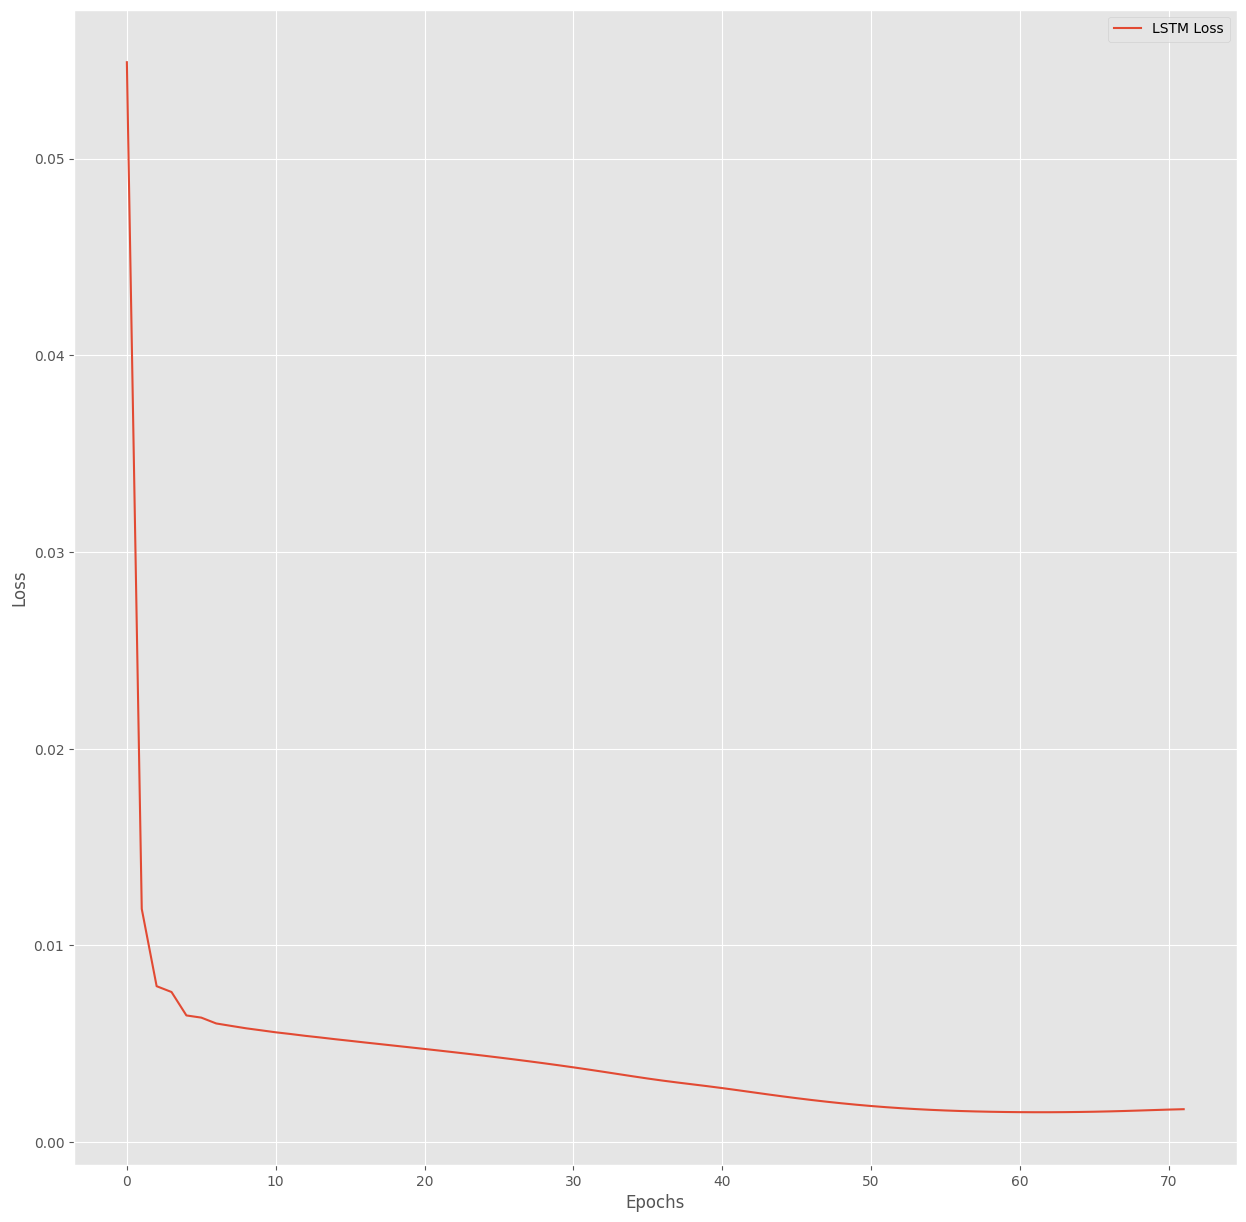

In [ ]:
early_stop = EarlyStopping(monitor='loss', patience=10)

model_lstm.compile(optimizer='adam', loss='mse')

history_lstm = model_lstm.fit(train_dataset,
                              epochs=100,
                              batch_size=batch_size,
                              verbose=1,
                              validation_data=val_dataset,
                              callbacks=[early_stop])

# Визуализация процесса обучения
plt.plot(history_lstm.history['loss'], label='LSTM Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 398ms/step
Val MSE: 0.0271


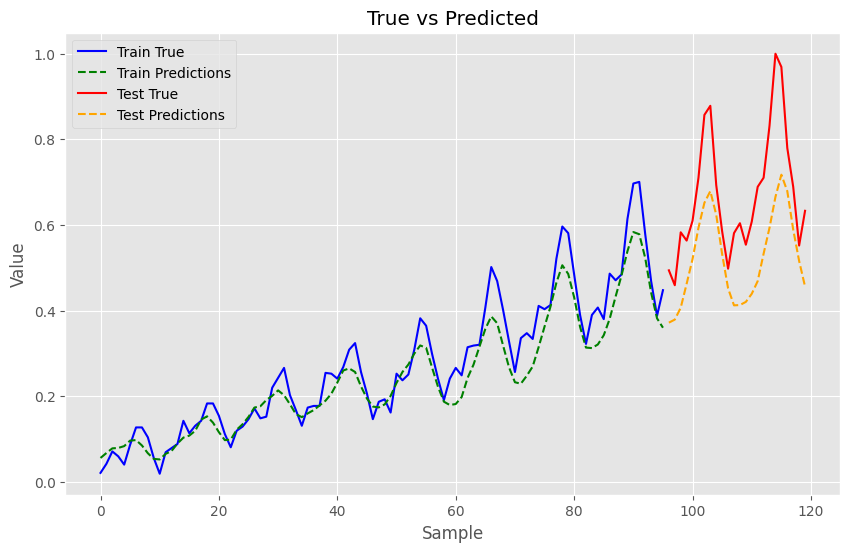

In [ ]:
lstm_predict_train = model_lstm.predict(X_train).flatten()
lstm_predict_true = model_lstm.predict(X_val).flatten()
print(f"Val MSE: {history_lstm.history['val_loss'][-1]:.4f}")

plot_predictions(y_train, lstm_predict_train, y_val, lstm_predict_true)

Реккурентная сеть с одним слоем LSTM показывает результат значительно хуже, чем сеть с одним слоем Simple RNN. По графику предсказаний видно, что нейронная сеть хуже улавливает волатильность. Возможно, сеть со слоём Simple RNN каким-то образом слишком подстраивается под обучающие данные, и на данных, которые нейронная сеть не видела, LSTM покажет результат лучше.

## 3. GRU

Обучим теперь рекуррентную нейросеть со слоём GRU, сравним с остальными.

In [ ]:
model_gru = tf.keras.Sequential([
    tf.keras.layers.GRU(64,
                        input_shape=(input.shape[1], input.shape[2])),
    tf.keras.layers.Dense(1)])

model_gru.summary()

Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_5 (GRU)                 (None, 64)                12864     
                                                                 
 dense_54 (Dense)            (None, 1)                 65        
                                                                 
Total params: 12929 (50.50 KB)
Trainable params: 12929 (50.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/100
12/12 [==============================] - 3s 45ms/step - loss: 0.0231 - val_loss: 0.0202
Epoch 2/100
12/12 [==============================] - 0s 8ms/step - loss: 0.0088 - val_loss: 0.0425
Epoch 3/100
12/12 [==============================] - 0s 8ms/step - loss: 0.0073 - val_loss: 0.0300
Epoch 4/100
12/12 [==============================] - 0s 9ms/step - loss: 0.0061 - val_loss: 0.0228
Epoch 5/100
12/12 [==============================] - 0s 8ms/step - loss: 0.0054 - val_loss: 0.0236
Epoch 6/100
12/12 [==============================] - 0s 8ms/step - loss: 0.0054 - val_loss: 0.0206
Epoch 7/100
12/12 [==============================] - 0s 7ms/step - loss: 0.0051 - val_loss: 0.0204
Epoch 8/100
12/12 [==============================] - 0s 7ms/step - loss: 0.0050 - val_loss: 0.0195
Epoch 9/100
12/12 [==============================] - 0s 8ms/step - loss: 0.0049 - val_loss: 0.0191
Epoch 10/100
12/12 [==============================] - 0s 8ms/step - loss: 0.0048 - val_loss: 0.0185
Epoch 11

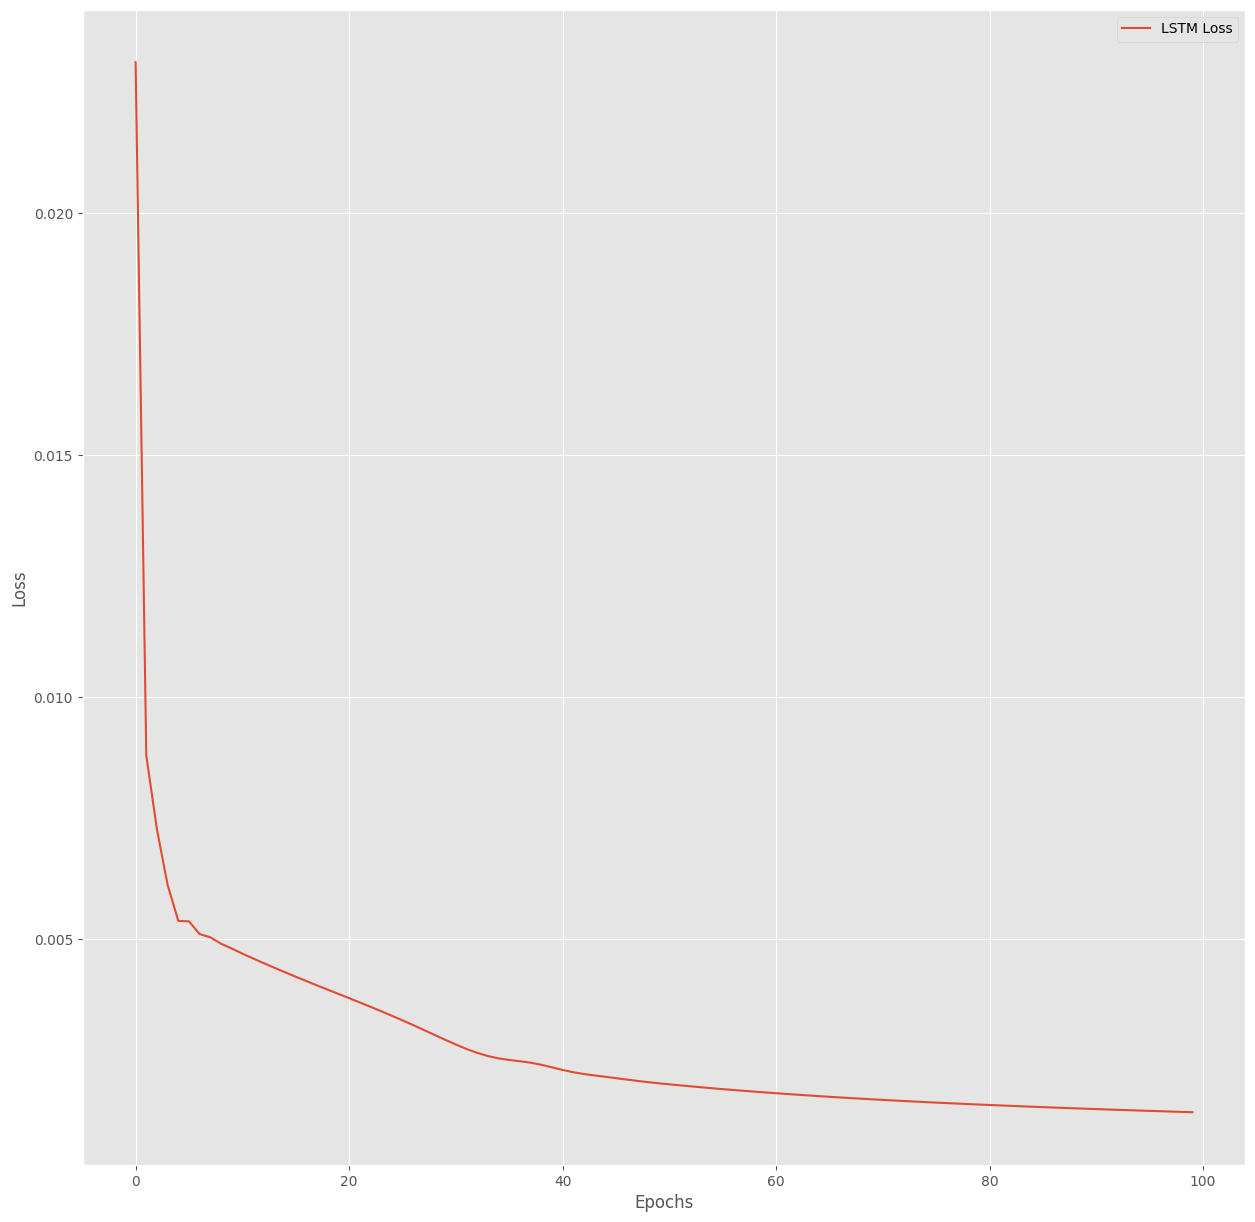

In [ ]:
early_stop = EarlyStopping(monitor='loss', patience=10)

model_gru.compile(optimizer='adam', loss='mse')

history_gru = model_gru.fit(train_dataset,
                              epochs=100,
                              batch_size=batch_size,
                              verbose=1,
                              validation_data=val_dataset,
                              callbacks=[early_stop])

# Визуализация процесса обучения
plt.plot(history_gru.history['loss'], label='LSTM Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 371ms/step
Val MSE: 0.0067


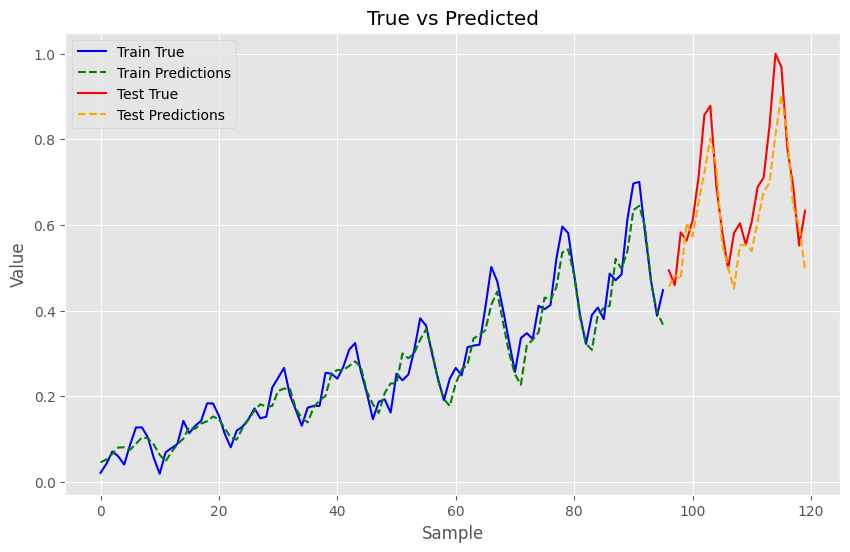

In [ ]:
gru_predict_train = model_gru.predict(X_train).flatten()
gru_predict_true = model_gru.predict(X_val).flatten()
print(f"Val MSE: {history_gru.history['val_loss'][-1]:.4f}")

plot_predictions(y_train, gru_predict_train, y_val, gru_predict_true)

GRU-слой так же показал высокое качество - выше, чем сеть со слоём LSTM, но несколько хуже, чем Simple RNN.

## 4. Simple RNN + LSTM + GRU

Попробуем построить нейронную сеть со всеми рекуррентными слоями и посмотрим, что получится.

In [ ]:
model_all = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(64, input_shape=(input.shape[1], input.shape[2]), return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.GRU(64),
    tf.keras.layers.Dense(1)])

model_all.summary()

Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_48 (SimpleRNN)   (None, 12, 64)            4224      
                                                                 
 lstm_7 (LSTM)               (None, 12, 64)            33024     
                                                                 
 gru_6 (GRU)                 (None, 64)                24960     
                                                                 
 dense_55 (Dense)            (None, 1)                 65        
                                                                 
Total params: 62273 (243.25 KB)
Trainable params: 62273 (243.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/100
12/12 [==============================] - 6s 95ms/step - loss: 0.0196 - val_loss: 0.0397
Epoch 2/100
12/12 [==============================] - 0s 17ms/step - loss: 0.0055 - val_loss: 0.0376
Epoch 3/100
12/12 [==============================] - 0s 17ms/step - loss: 0.0046 - val_loss: 0.0326
Epoch 4/100
12/12 [==============================] - 0s 18ms/step - loss: 0.0036 - val_loss: 0.0392
Epoch 5/100
12/12 [==============================] - 0s 16ms/step - loss: 0.0027 - val_loss: 0.0424
Epoch 6/100
12/12 [==============================] - 0s 17ms/step - loss: 0.0022 - val_loss: 0.0251
Epoch 7/100
12/12 [==============================] - 0s 17ms/step - loss: 0.0018 - val_loss: 0.0239
Epoch 8/100
12/12 [==============================] - 0s 19ms/step - loss: 0.0016 - val_loss: 0.0241
Epoch 9/100
12/12 [==============================] - 0s 17ms/step - loss: 0.0016 - val_loss: 0.0200
Epoch 10/100
12/12 [==============================] - 0s 16ms/step - loss: 0.0015 - val_loss: 0.0189

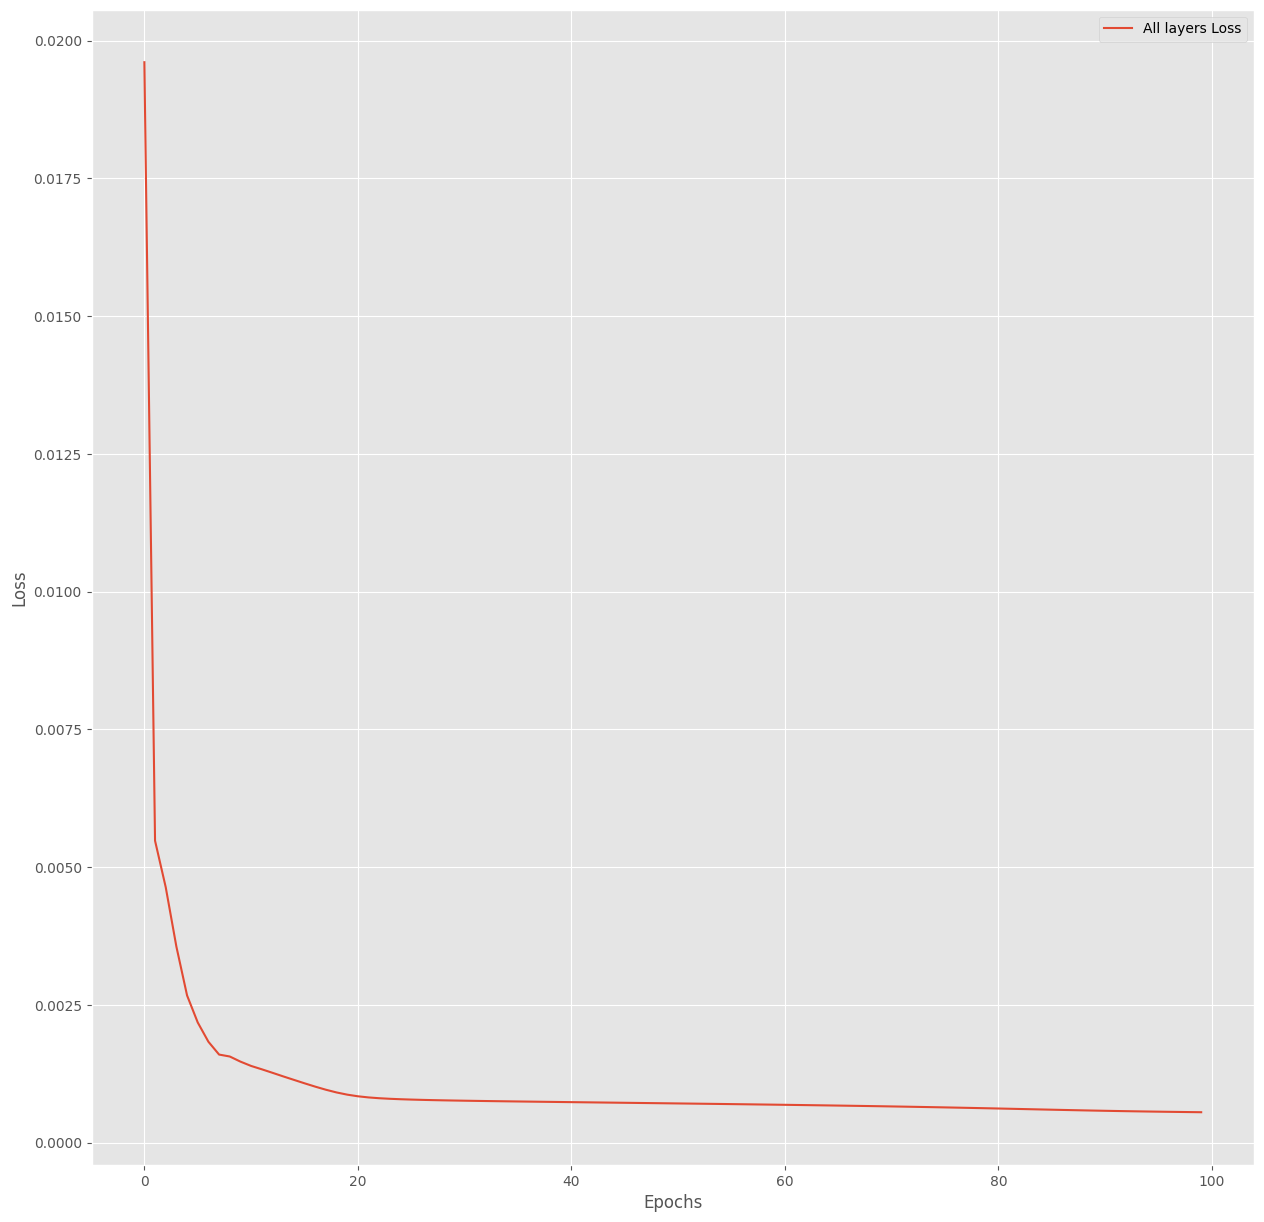

In [ ]:
early_stop = EarlyStopping(monitor='loss', patience=10)

model_all.compile(optimizer='adam', loss='mse')

history_all = model_all.fit(train_dataset,
                              epochs=100,
                              batch_size=batch_size,
                              verbose=1,
                              validation_data=val_dataset,
                              callbacks=[early_stop])

# Визуализация процесса обучения
plt.plot(history_all.history['loss'], label='All layers Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 [==============================] - 1s 856ms/step
Val MSE: 0.0028


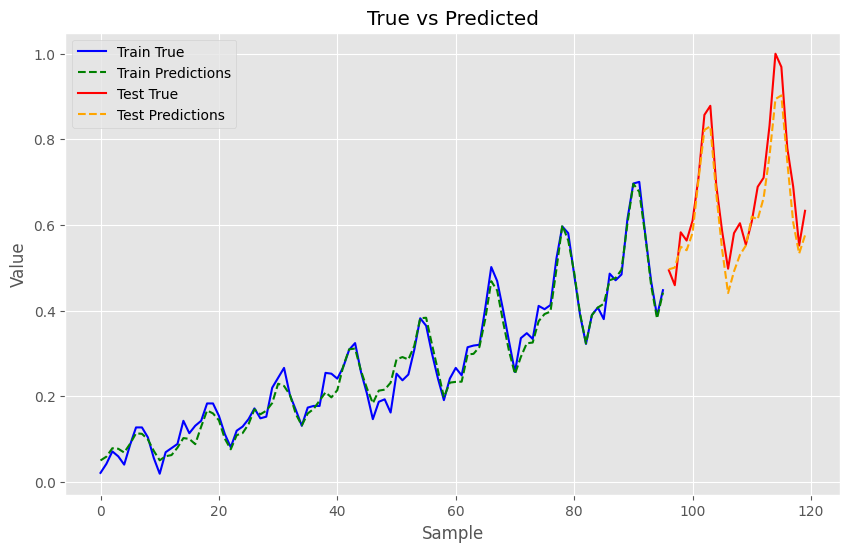

In [ ]:
all_predict_train = model_all.predict(X_train).flatten()
all_predict_true = model_all.predict(X_val).flatten()
print(f"Val MSE: {history_all.history['val_loss'][-1]:.4f}")

plot_predictions(y_train, all_predict_train, y_val, all_predict_true)

# Выводы

Имеем следующие результаты:
* Simple RNN показала качество MSE = 0.0012;
* LSTM показала MSE = 0.0128;
* GRU показала MSE = 0.0063;
* Simple RNN + LSTM + GRU показала MSE = 0.0136.

* Лучше всех отработала самая простая нейронная сеть с одним слоем Simple RNN;
* Хуже всех на тестовых данных отработал слой LSTM;
* Очень высокое качество на тестовых данных может говорить о том, что наши данные имеют слишком простую и очевидную структуру, что даже самая простая нейросеть имеет очень высокое качество;
* Возможно, ради эксприментов стоит убрать станционарность ряда (логарифмирование, сезонная дифференциация и так далее) и построить ARIMA-модель или же использовать градиентные бустинги.